# Tweets pre-processing
This article aims to illustrate a text pre-processing methodology for Natural Language Processing (NLP) for detection of cyberthreats.

Text samples with cyber incriminatory text has been obtained from the AZSecure-data.org portal, which is published and maintained by the University of Arizona, whereas further samples and control text were streamed and captured with relevant filtered requests to Twitter API.

The data has been previously captured and stored in two different databases (DB): 1) a MySQL DB holds the AZSecure dataset and, 2) MongoDB stores the Tweets previously captured with Twitter API filtered streams.

The article will be divided in two sections:
1. Database connections
2. Code general use function
3. AZSecure dataset pre-processing
4. Twitter cyberthreat dataset pre-processing
5. Twitter cyberbulling dataset pre-processing
6. Twitter streams pre-processing

Let's import in first place some general packages we will use during the text pre-processing step:

In [1]:
import copy
import os
import csv
import string
from datetime import datetime

import numpy as np
import pandas as pd
from typing import Dict, List, Set, Tuple
from collections import Counter

from PIL import Image
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer, Tokenizer
from ekphrasis.dicts.emoticons import emoticons

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import download
from nltk import pos_tag

import tensorflow as tf
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.optimization
# import official.nlp.bert.bert_models
# import official.nlp.bert.configs
# import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

import wordninja

In [2]:
# download('punkt')
# download('averaged_perceptron_tagger')
# download('wordnet')
# download('omw-1.4')
# download('stopwords')
# gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
# tf.io.gfile.listdir(gs_folder_bert)

## Database connections
During this pre-processing stage, three different databases will be employed to prepare the input data of the NLP models where this data will be employed by a NLP model which will forecast a potential cyber threat which might be triggered in Twitter platform.

Two DB clients will be set up during this section: a MongoDB client and a MySQL client.

### Setting up a MongoDB client
In first place, a `MongoClient` class from `pymongo` library will be imported:

In [3]:
from pymongo import MongoClient

Since the instantiation of a `MongoClient` object requires user credentials and point to a certain the host and port of the target MongoDB server to establish connection. It is required to create a YAML file with the following parameters:
```yaml
[MONGO_CREDENTIALS_KEY]:
  user: <MONGO_USERNAME>
  password: <MONGO_PASSWORD>
  host: <MONGO_HOST>
  port: <MONGO_PORT>
```

The `yaml` library has to be imported to be able to parse the YAML file with the connection settings:

In [4]:
import yaml

The client connection settings will be extracted from the YAML file with the following function:

In [5]:
def load_db_credentials(file_credentials=None, credential_key=None):
    with open(file_credentials) as stream:
        try:
            credentials = yaml.safe_load(stream)[credential_key]
            user = credentials['user']
            password = credentials['password']
            host = credentials['host']
            port = credentials['port']
        except yaml.YAMLError as e:
            print(e)
    return host, password, port, user

A `MongoClient` object will be instantiated once the connection and credential details has been retrieved. A connection to cyberthreat and cyberbulling servers will be established:

In [6]:
host, password, port, user = load_db_credentials(file_credentials='../credentials.yaml',
                                                        credential_key='mongodb_cyberthreat_credentials')

cyberthreat_conn = MongoClient(f"mongodb://{user}:{password}@{host}:{port}")
cyberthreat_conn = cyberthreat_conn.threat

host, password, port, user = load_db_credentials(file_credentials='../credentials.yaml',
                                                        credential_key='mongodb_cyberbulling_credentials')

cyberbulling_conn = MongoClient(f"mongodb://{user}:{password}@{host}:{port}")
cyberbulling_conn = cyberbulling_conn.cyberbulling

### Setting up MySQL client
There is an official MySQL package named `mysql-connector-python` which contains a MySQL connector for Python. This library requires the instantiation of an object called MySQLConnection.

In [7]:
from mysql.connector import (connection)
from mysql.connector.connection import MySQLCursor, MySQLConnection
from mysql.connector.errors import IntegrityError

As mentioned earlier, a connection setting YAML file has to be created for the sake of connecting and authenticating with MySQL server. The YAML file credentials file has the following structure:

```yaml
[MYSQL_CREDENTIALS_KEY]:
  user: <MYSQL_USERNAME>
  password: <MYSQL_PASSWORD>
  host: <MYSQL_HOST>
  port: <MYSQL_PORT>
```

AZSecure and the resulting pre-processed datasets resides in separate MySQL server, the following step consists on instantiating two different clients by selecting the suitable credential key to the `load_db_credentials` function:

In [8]:
azs_host, azs_password, azs_port, azs_user = load_db_credentials(file_credentials='../credentials.yaml',
                                                                 credential_key='mysql_azsecure_credentials')
azs_mysql = connection.MySQLConnection(user=azs_user, password=azs_password, host=azs_host, port=azs_port, database='cyberthreat')
azs_db = azs_mysql.cursor()


dw_host, dw_password, dw_port, dw_user = load_db_credentials(file_credentials='../credentials.yaml',
                                                             credential_key='mysql_dw_dataset_credentials')
dw_db = connection.MySQLConnection(user=dw_user, password=dw_password, host=dw_host, port=dw_port, database='cyberthreat')
dw_cursor = dw_db.cursor()

## General use functions
In this section we will create general use function that will likely be used several times during the pre-preprocessing stage.

### Determine Pandas type
This function determines the type of data type and returns the corresponding string representing the pandas `dtype` value.

In [9]:
def get_pandas_dtype(value = None, is_categorical = False):
    if isinstance(value, float):
        return "float64"
    elif isinstance(value, int):
        return "int64"
    elif isinstance(value, str):
        return "string"
    elif isinstance(value, bool):
        return "boolean"
    elif is_categorical:
        return "categorical"
    else:
        return "object"

### Count duplicates in a certain column
This function will group the data by a certain column and return the count of duplicated values.

In [10]:
def duplicated_column_value_count(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    dup_count_df = df.pivot_table(columns=columns, aggfunc='size')
    return dup_count_df[dup_count_df[:] > 1]

### Return the number of duplicate rows per column
This function will returned the number of duplicates found per column in a certain instance of a pandas Dataframe.

In [11]:
def duplicate_count(df: pd.DataFrame) -> pd.DataFrame:
    data = {}
    for column in df.columns:
        data[column] = duplicated_column_value_count(df, column).sum()

    dup_count_df = pd.DataFrame(data, index=['duplicates'])
    return dup_count_df.T

### Filter rows by a minimum word count
This function will filter rows which its word count is equal or greater than a certain value.

In [12]:
def filter_by_word_count(df: pd.DataFrame, column_name: str, word_count: int = 10) \
        -> pd.DataFrame:
    count = df[column_name].str.split().str.len()
    return df[count >= word_count]

### Retrieve table names inside in a certain MySQL database
The following function returns a `Dataframe` with the list of table names stored in a certain database.

In [13]:
def fetch_all_mysql_tablenames(db_cursor) -> pd.DataFrame:
    db_cursor.execute('SHOW TABLES;')
    tb_data = { 'table_name': [x[0] for x in db_cursor.fetchall()] }
    return pd.DataFrame(data=tb_data, dtype=str)

### Load MySQL table in a Dataframe
This function will load the entire table content of a certain MySQL table into a pandas Dataframe` object.

In [14]:
def load_mysql_in_dataframe(table_name: str, db_cursor) -> pd.DataFrame:
    db_cursor.execute(f'SELECT * FROM {table_name};')
    table_data = np.array(db_cursor.fetchall())
    table_cols = db_cursor.column_names

    data = {}
    for i, col in enumerate(table_cols):
        column_data = table_data[:, i]
        column_dtype = get_pandas_dtype(column_data[0])
        data.update({col: pd.Series(column_data, dtype=column_dtype)})

    return pd.DataFrame(data)

### Load MongoDB collection in Dataframe
This function fetches records from a certain MongoDB collection and loads it into a pandas `Dataframe` object.

In [15]:
def load_mongodb_collection_in_dataframe(collection_name: str, db_cursor: MongoClient) -> pd.DataFrame:
    return pd.DataFrame(db_cursor[collection_name].find())

### Create text preprocessor with ekphrasis library
Most of the pre-processing work will be taken by the `TextPreProcessor` object from the Python library `ekphrasis`.

This text pre-processor will be able to normalize non-emotion related words like URL, emails, numbers, percentages, money amounts, phone numbers, users and/or date/times.

The same object will also be able to annotate sentiment related words like hashtags and censored words. All capitalizations, elongated or repeated data extructures can also be annotated by `TextPreProcessor`.

This library can also apply word segmentation on hashtags, spell correction mechanisms and corpus tokenization.

Additionally, it is possible to pass a list of dictionaries for replacing tokens extracted from the text with other expressions. This functionality is useful for tokenizing emoticons found in the text.

In [16]:
def get_text_preprocessor(normalize: list = ['url', 'email', 'percent', 'money', 'phone',
                                             'user', 'time', 'date', 'number'],
                          annotate: list = {"hashtag", "allcaps", "elongated", "repeated",
                                            'emphasis', 'censored'},
                          fix_html: bool = True,
                          segmenter: str = "twitter",
                          corrector: str = "twitter",
                          unpack_hashtags: bool = True,
                          unpack_contractions: bool = True,
                          spell_correction: bool = True,
                          spell_correct_elong: bool = False,
                          all_caps_tag: str = 'wrap',
                          tokenizer: object = None,
                          dicts: list = [emoticons],
                          pipeline: list = ["URL", "EMOJI", "TAG", "EMAIL", "USER", "HASHTAG", "CASHTAG", "PHONE", "PERCENT", "MONEY", "DATE", "TIME", "ACRONYM",
                                            "LTR_FACE", "RTL_FACE", "CENSORED", "EMPHASIS", "REST_EMOTICONS", "NUMBER", "WORD", "EASTERN_EMOTICONS"]) \
        -> TextPreProcessor:
    if tokenizer is None:
        tokenizer = Tokenizer(pipeline=pipeline, lowercase=True).tokenize

    return TextPreProcessor(
        normalize=normalize,
        annotate=annotate,
        fix_html=fix_html,
        segmenter=segmenter,
        corrector=corrector,
        unpack_hashtags=unpack_hashtags,
        unpack_contractions=unpack_contractions,
        spell_correction=spell_correction,
        spell_correct_elong=spell_correct_elong,
        all_caps_tag=all_caps_tag,
        tokenizer=tokenizer,
        dicts=dicts
    )

### Plot WordCloud
The following function will find the most common word and plot them in a figure in which the word size is proportional to its frequency.

In [156]:
def plot_wordcloud(posts: str, stopwords: list = [], max_words: int = 50, use_stopwords_pack: bool = False) -> None:
    if use_stopwords_pack:
        stopwords.extend(STOPWORDS)
        stopwords.extend(sw.words('english'))

    stopwords = set(stopwords)
    wordcloud = WordCloud(max_words=max_words, stopwords=stopwords, background_color='white', collocations=False).generate(posts)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Calculate word frequency
This function returns the word frequency of the whole dataset:

In [18]:
def word_frequency(posts: pd.DataFrame, post_column_name: str, stopwords: list = [], max_top_rank: int = 50) -> Dict:
    posts = ". ".join(posts.drop_duplicates()[post_column_name].fillna('').tolist())
    posts = get_text_preprocessor().pre_process_doc(posts)
    sw = set(STOPWORDS)
    sw.update(stopwords)
    return Counter(WordCloud(max_words=max_top_rank, stopwords=sw, background_color='white').process_text(posts)).most_common(max_top_rank)

### Load full emoji/emoticon dictionary
It loads full emoji/emoticon dictionary pictograms:

In [19]:
def load_emojis_emoticon(csv_file: str, emo_key: str, emo_value: str) -> Dict:
    csv_file = open(csv_file)
    csvreader = csv.reader(csv_file)

    headers = next(csvreader)
    emojis = {}
    for row in csvreader:
        key = ""
        value = ""
        for i, data in enumerate(row):
            if headers[i] == emo_key:
                key = data
            if headers[i] == emo_value:
                value = f'<{data}>'

        emojis[key] = value

    return emojis

### Merge emoticon/emoji dictionary
Call the next function to merge the emoticons and emojis dictionaries:

In [20]:
def merge_emoji_emoticon_dictionaries(emoji_dict: Dict, emoticon_dict: Dict, remove_html_tags=True) -> None:
    emoticons.update(emoji_dict)
    emoticons.update(emoticon_dict)

    if remove_html_tags:
        for symbol, value in emoticons.items():
            emoticons[symbol] = value.replace("<", "").replace(">", "")

    return emoticons

In [21]:
emoji_dict = load_emojis_emoticon('../datasets/full-emoji-dataset/full_emoji.csv', 'emoji', 'name')
emoticon_dict = load_emojis_emoticon('../datasets/full-emoticons-dataset/full-emoticons-dataset.csv', 'Emoticon', 'Meaning')
merge_emoji_emoticon_dictionaries(emoji_dict, emoticon_dict)

{':*': 'Kiss',
 ':-*': 'Secret Telling',
 ':x': 'Love Struck',
 ':-)': 'happy',
 ':-))': 'happy',
 ':-)))': 'Overweight',
 ':-))))': 'happy',
 ':-)))))': 'happy',
 ':-))))))': 'happy',
 ':)': 'Smile',
 ':))': 'happy',
 ':)))': 'happy',
 ':))))': 'happy',
 ':)))))': 'happy',
 ':))))))': 'happy',
 ':)))))))': 'happy',
 ':o)': 'happy',
 ':]': 'happy',
 ':3': 'Naughty Grin',
 ':c)': 'happy',
 ':>': 'Smug',
 '=]': 'happy',
 '8)': 'Dumb Person',
 '=)': 'happy',
 ':}': 'happy',
 ':^)': 'I Do Not Know',
 '|;-)': 'happy',
 ":'-)": 'happy',
 ":')": 'happy',
 '\\o/': 'Praise The Lord',
 '*\\0/*': 'happy',
 ':-D': 'laugh',
 ':D': 'Big Grin',
 '8-D': 'laugh',
 '8D': 'laugh',
 'x-D': 'laugh',
 'xD': 'laugh',
 'X-D': 'laugh',
 'XD': 'Hyper',
 '=-D': 'laugh',
 '=D': 'Very Happy',
 '=-3': 'laugh',
 '=3': 'laugh',
 'B^D': 'laugh',
 '>:[': 'Glaring',
 ':-(': 'Frowning',
 ':-((': 'Very Sad',
 ':-(((': 'sad',
 ':-((((': 'sad',
 ':-(((((': 'sad',
 ':-((((((': 'sad',
 ':-(((((((': 'sad',
 ':(': 'Turtle',
 ':

### Lemmatization with WordNet
The following function will tag a list of tokens and find its corresponding lemmatization with WordNet:

In [22]:
def wordnet_lemmatization(sentence_tokens):
    tag_dict = {
        "J": wn.ADJ,
        "N": wn.NOUN,
        "V": wn.VERB,
        "R": wn.ADV
    }

    word_tags = pos_tag(sentence_tokens)

    lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word_tag in word_tags:
        word = word_tag[0]
        tag = word_tag[1]
        if tag[0] == 'N':
            tag = 'N'
        elif tag[0] == 'J':
            tag = 'J'
        elif tag[0] == 'V':
            tag = 'V'
        elif tag[0] == 'R':
            tag = 'R'

        lemma_list.append(lemmatizer.lemmatize(word, tag_dict.get(tag, wn.NOUN)))

    return lemma_list

### Remove posts with certain pattern
Before every preprocessing step, certain posts have to be erased from the dataset because they could bring noise to the dataset with irrelevant patterns which the Language Model could learn from. These undesired patterns can be removed from the dataset with the following function:

In [23]:
def remove_posts_with_pattern(df: pd.DataFrame, column_name: str, pattern: str, case: bool = True) -> pd.DataFrame:
    filter = df[column_name].str.contains(pattern, case=case, regex=True)
    return df[~filter]

### Replace post patterns
Some characters and/or patterns can be replaced in order to cleanse the input data.

In [24]:
def replace_post_patterns(df: pd.DataFrame, column_name: str, patterns: str | List, value: str) -> pd.DataFrame:
    return df[column_name].replace(to_replace=patterns, value=value, regex=True)

### Remove duplicate & fill empty posts
This function removes duplicate and fills empty posts.

In [25]:
def remove_duplicate_empty_posts(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    return df[column_name].drop_duplicates().dropna()

### Generate vocabulary
The following function generates a vocabulary file and retuns a vocabulary set with associated word counts.

In [26]:
def generate_vocabulary(token_db: List, vocab_file: str = 'vocab.txt', extra_tokens: List = []) -> Tuple[Set, Counter]:
    vocab_count = Counter(extra_tokens)
    for tokens in token_db:
        vocab_count.update(tokens)
    vocab = set(vocab_count.keys())

    content = "\n".join(vocab).encode('utf-8')
    open(vocab_file, 'wb').write(content)

    return vocab_count

### Remove non-semantic tokens
This function removes tokens which won't contribute to the overall semantic value of the document.

In [27]:
def remove_non_semantic_tokens(token_db: List[str], remove_stopwords: bool = True, remove_punctuation: bool = True,
                               min_token_size: int = 3) -> List:
    cleansed_token_db = []
    for tokens in token_db:
        cleansed_tokens = []
        for token in tokens:
            is_stopword = token in sw.words('english') or token in STOPWORDS
            if remove_stopwords and is_stopword:
                continue
            if remove_punctuation and not token.isalpha():
                continue
            if len(token) < min_token_size:
                continue
            cleansed_tokens.append(token)
        cleansed_token_db.append(cleansed_tokens)
    return cleansed_token_db

### Add token paddings
This function will add padding until the token vector reach the maximum token size.

In [28]:
def add_token_paddings(token_set: List, max_tokens: int = 512):
    for i, tokens in enumerate(token_set):
        if len(tokens) > max_tokens:
            tokens[max_tokens-1] = tokens[-1]
            tokens = tokens[:max_tokens]
        elif len(tokens) < max_tokens:
            padding = max_tokens - len(tokens)
            tokens = tokens + ['[PAD]'] * padding
        token_set[i] = tokens

### Generate token IDs
Tokens are translated into a unique ID value which will then be passed to the Language Model.

In [29]:
def generate_token_ids(token_db: List, vocab_file: str,
                       token_db_no_padding: List, max_tokens: int = -1) -> Tuple[List, List, List]:
    token_ids = []
    input_masks = []
    type_ids = []
    tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=True)
    for tokens, tokens_no_padding in zip(token_db, token_db_no_padding):
        tokens_length = len(tokens)
        tokens_no_padding_length = len(tokens_no_padding)
        if not max_tokens < 0 and tokens_length > max_tokens:
            tokens[max_tokens-1] = tokens[-1]
            tokens = tokens[:max_tokens]

        ids = tokenizer.convert_tokens_to_ids(tokens)
        mask = [1] * tokens_no_padding_length
        if not max_tokens < 0 and tokens_no_padding_length < max_tokens:
            padding = max_tokens - tokens_no_padding_length
            mask = mask + [0] * padding
        type_id = [0] * tokens_length

        token_ids.append(ids[:max_tokens])
        input_masks.append(mask[:max_tokens])
        type_ids.append(type_id[:max_tokens])

    return token_ids, input_masks, type_ids

### Retrieve preprocessed posts
This functions rebuilds the posts from tokens, resulting in a preprocessed version of the original post.

In [30]:
def get_preprocessed_post(tokenized_posts: List) -> List:
    posts = []
    for tokens in tokenized_posts:
        post = " ".join(tokens)
        posts.append(post)
    return posts

### Text preprocessing
Several pre-processing tasks will be applied in the sample sentences. Some pre-processing jobs will be:
1. Removal of duplicates (Mandatory)
2. Fill null values with empty strings (Mandatory)
3. Punctuation removal
4. Stopwords removal
5. Token lower casing (Mandatory)
6. Token WordNet lemmatization
7. Appending a `[CLS]` and `[SEP]` token at the begginning and ending of each sentence (Mandatory)
8. Converting tokens to IDs (Mandatory)
9. Sentence masking (Mandatory)

As a result from this pre-processing function, a matrix of tokens and IDs representing each sentence of the dataset, and its set of corresponding masks will be returned.

In [31]:
def preprocess_posts(posts: pd.DataFrame, column_name: str, tokenize: bool = True, mask: bool = True, annotate: Dict = {},
                     max_tokens: int = 512, case: bool = False, patterns: List = [], token_with_padding: bool = True,
                     remove_duplicates_fill_empty: bool = True, remove_stopwords: bool = True, min_token_length: int = 1,
                     remove_punctuation: bool = True, replace_patterns: List = [], replace_values: List = [],
                     lemmatize: bool = True, extra_tokens: List = ['[CLS]', '[SEP]', '[MASK]', '[UNK]'],
                     vocab_file: str = 'vocab.txt', tokens_to_ids: bool = True) -> Dict:
    result = {}
    if len(patterns) > 0:
        for pattern in patterns:
            posts = remove_posts_with_pattern(posts, column_name, pattern, case)

    if len(replace_patterns) > 0 and len(replace_values) > 0:
        for pattern, value in zip(replace_patterns, replace_values):
            posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)

    if remove_duplicates_fill_empty:
        posts = remove_duplicate_empty_posts(posts, column_name).tolist()

    if tokenize:
        tokenized_posts = list(get_text_preprocessor(annotate=annotate).pre_process_docs(posts))

        if lemmatize:
            tokenized_posts = [wordnet_lemmatization(lemmatized_post) for lemmatized_post in tokenized_posts]

        if remove_stopwords or remove_punctuation or min_token_length > 0:
            tokenized_posts = remove_non_semantic_tokens(tokenized_posts, remove_stopwords,
                                                         remove_punctuation, min_token_length)

        preprocessed_posts = get_preprocessed_post(tokenized_posts)
        result['preprocessed_text'] = preprocessed_posts

        tokenized_posts = [["[CLS]"] + post + ["[SEP]"] for post in tokenized_posts]

        tokenized_posts_no_padding = copy.deepcopy(tokenized_posts)

        if token_with_padding:
            add_token_paddings(tokenized_posts, max_tokens)

        vocab_stats = generate_vocabulary(tokenized_posts, vocab_file, extra_tokens)
        result['vocab_stats'] = vocab_stats

        if tokens_to_ids:
            token_ids, input_masks, type_ids = generate_token_ids(tokenized_posts, vocab_file,
                                                                  tokenized_posts_no_padding, max_tokens)
            result['token_ids'] = tf.convert_to_tensor(tf.constant(token_ids))
            result['input_masks'] = tf.convert_to_tensor(tf.constant(input_masks))
            result['type_ids'] = tf.convert_to_tensor(tf.constant(type_ids))

        result['tokens'] = tf.convert_to_tensor(tf.constant(tokenized_posts))

    if mask:
        pass

    result['text'] = posts
    return result

## AZSecure dataset processing
In the previous section we established connection to the MySQL server where the AZSecure dataset was stored. Let's have at the tables stored in the `cyberthreat` database:

In [32]:
tables = fetch_all_mysql_tablenames(azs_db)

In [33]:
tables[:]

,table_name
0,crackingarena_post
1,crackingfire_post
2,exetools_post
3,garage4hackers_posts
4,hackhoundposts


Since there are several tables in `cyberthreat` database with schemas and data structure, the tables and text samples will be analyzed and pre-processed individually.

### Cracking Arena Posts
This table contains posts from an underground hacking forum named __CrackingArena Forum__. A quick overview on the data will help on determining the table structure and understand what kind of information is stored in this table.

In [34]:
table_name = tables.loc[0, "table_name"]
table_name

'crackingarena_post'

The table contains the following data:

In [35]:
cracking_arena_db = load_mysql_in_dataframe(table_name, azs_db)
cracking_arena_db.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag,attachmentName,authorICQ
0,3,2,naked.com with credit,http:/www.crackingarena.com/naked-com-credit-2...,Dead Premium Accounts,kill3r_cool,None,Apr 2013,None,"04-08-2013,02:30AM",1,None,You do not have sufficient rights to see the h...,"<div id=""post_message_3""> <div st...",None,None
1,4,2,naked.com with credit,http:/www.crackingarena.com/naked-com-credit-2...,Dead Premium Accounts,lolzz,None,Apr 2013,None,"04-08-2013,02:38AM",2,None,thnxx xD lolzz,"<div id=""post_message_4""> thnxx x...",None,None
2,5,3,welcome to CrackingArena,http:/www.crackingarena.com/welcome-crackingar...,Old Announcements,kill3r_cool,None,Apr 2013,None,"04-08-2013,02:52AM",1,None,Hello to all members we are going to start new...,"<div id=""post_message_5""> Hello t...",None,None
3,12,2,naked.com with credit,http:/www.crackingarena.com/naked-com-credit-2...,Dead Premium Accounts,audi,None,Apr 2013,None,"04-08-2013,03:11PM",3,None,Thanks for this,"<div id=""post_message_12""> Thanks...",None,None
4,14,6,Sql Injection Tutorial Step By Step,http:/www.crackingarena.com/bypass-surveys-173...,Hacking Tutorials,unrated,None,Apr 2013,None,"04-08-2013,03:54PM",1,None,SQL Injection Tutorial What is an SQL Injectio...,"<div id=""post_message_14""> SQL In...",None,None


There are a total of 44927 posts and 16 columns stored in this table.

In [36]:
cracking_arena_db.shape

(44927, 16)

In [37]:
cracking_arena_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44927 entries, 0 to 44926
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                44927 non-null  int64 
 1   threadID              44927 non-null  int64 
 2   threadTitle           44927 non-null  string
 3   URL                   44927 non-null  string
 4   subforum              44927 non-null  string
 5   authorName            44927 non-null  string
 6   postAuthorMembership  0 non-null      object
 7   postAuthorJoinDate    44728 non-null  string
 8   authorReputation      0 non-null      object
 9   postDate              44927 non-null  string
 10  postSequence          44927 non-null  int64 
 11  likes                 0 non-null      object
 12  flatContent           44927 non-null  string
 13  contentWithHTMLTag    44927 non-null  string
 14  attachmentName        16 non-null     object
 15  authorICQ             0 non-null    

#### Duplicates

In [38]:
duplicate_count(cracking_arena_db)

,duplicates
postID,0
threadID,42131
threadTitle,42797
URL,35701
subforum,44925
authorName,38903
postAuthorMembership,0
postAuthorJoinDate,44728
authorReputation,0
postDate,3463


In [39]:
duplicated_column_value_count(cracking_arena_db, ['flatContent'])

flatContent
                                      175
+++++++++++++                           2
++++++++++++++++++++                    2
...........                             3
............                            3
                                     ... 
you can also put me there               2
yyyyyyyyyyyyy                           2
yyyyyyyyyyyyyyyyyyyyyyyy                2
zzzzzzzzzzzzz                           2
سسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسس      2
Length: 2645, dtype: int64

#### Pre-processing

In [40]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
titles_cracking_arena = preprocess_posts(cracking_arena_db, 'threadTitle', patterns=patterns, replace_patterns=['’'],
                                          replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)
/opt/apps/anaconda3/envs/cyberattack-forecasting/lib/python3.10/site-packages/ekphrasis/classes/tokenizer.py:49: FutureWarning: Possible nested set at position 9301
  self.tok = re.compile(r"({})".format("|".join(self.pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/opt/apps/anaconda3/envs/cyberattack-forecasting/lib/python3.10/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
PreProcessing...:  25%|██▍       | 1199/4837 [00:00<00:00, 11987.95it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 4837/4837 [00:00<00:00, 10205.05it/s]
2022-04-24 17:48:51.675709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 17:48:53.257624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 17:48:53.258043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 17:48:53.259592: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in

In [41]:
len(titles_cracking_arena['text'])

4837

In [42]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
posts_cracking_arena = preprocess_posts(cracking_arena_db, 'flatContent', patterns=patterns, replace_patterns=['’'],
                                          replace_values=['\''], remove_stopwords=True, remove_punctuation=False)
# /(?<!\w+)(([t]+[hanksxz]*|x+)+[ ]*([y]+[ou]*)*)+(?=\W+)/gi
# /(?<!\w+)((t+[hanksxz]*|x+)(?![tn ])[ ]*([y]+[ou]*)*)+(?=\W+)/gi
# /(?<!\w+)((t+[hanksxz]*|x+)([ y]+[ou]*)*)+(?=\W+|$)/gi
# /((?<=\W+|^|[y]+[ou]*)(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\W+|$)/gi
# /((?<=[^a-zA-Z0-9'’]+|^|[y]+[ou]*)(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\W+|$)/gi
# And there are less than 10 words

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)


Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   2%|▏         | 144/9380 [00:00<00:06, 1439.63it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 9380/9380 [00:01<00:00, 4882.11it/s]


In [43]:
len(posts_cracking_arena['text'])

9380

#### Word cloud
Wordcloud extracted from post titles:

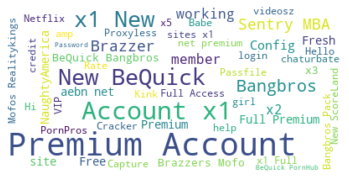

In [44]:
cracking_arena_title_doc = " ".join(titles_cracking_arena['text'])
plot_wordcloud(cracking_arena_title_doc, max_words = 50, use_stopwords_pack=True)

Wordcloud extracted from post titles:

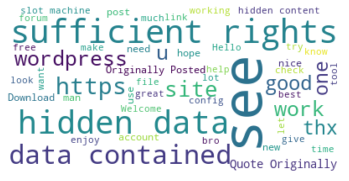

In [45]:
cracking_arena_post_doc = " ".join(posts_cracking_arena['text'])
plot_wordcloud(cracking_arena_post_doc, max_words = 50, use_stopwords_pack=True)

### Cracking Fire
This dataset was extracted from __Cracking Fire__ forum. Let's have a look to how the daat looks like:

In [46]:
table_name = tables.loc[1, "table_name"]
table_name

'crackingfire_post'

The dataset content contains the following data:

In [47]:
cracking_fire_db = load_mysql_in_dataframe(table_name, azs_db)
cracking_fire_db.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag,attachmentName,authorICQ
0,60,28,How to all websites in a server!,https://crackingfire.net/threads/how-to-all-we...,Hacking Zone,viruslover,Well-Known Member,None,None,"Jan 30, 2012 at 4:50 PM",1,None,Hi guys! As i know there are two way to find t...,Hi guys!<br /> <br /> As i kno...,None,None
1,68,33,Xss in airtel.in by satz and Darker,https://crackingfire.net/threads/xss-in-airtel...,Hacking Zone,viruslover,Well-Known Member,None,None,"Jan 31, 2012 at 4:15 PM",1,None,I am very happy because this is the first thre...,I am very happy because this is ...,None,None
2,1287,732,Bunch of sql vulnerable links my collection!!,https://crackingfire.net/threads/bunch-of-sql-...,Hacking Zone,T3am HH,Guest,None,None,"Apr 7, 2011 at 3:16 PM",1,None,Code: http://www.solutionfocusedtrainers.co.uk...,"<div class=""bbCodeBlock bbCodeCo...",None,None
3,1294,736,Google dorks for sql injection!!!!,https://crackingfire.net/threads/google-dorks-...,Hacking Zone,T3am HH,Guest,None,None,"Apr 13, 2011 at 1:46 PM",1,None,"Code: inurl:""id="" & intext:""Warning: mysql_fet...","<div class=""bbCodeBlock bbCodeCo...",None,None
4,1315,749,[app]How to find admin path of a website?,https://crackingfire.net/threads/app-how-to-fi...,Hacking Zone,T3am HH,Guest,None,None,"May 1, 2011 at 8:54 AM",1,None,here is a good tool to find admin path of a we...,here is a good tool to find admi...,None,None


There is a total of 37572 entries and 16 columns stored in this table.

In [48]:
cracking_fire_db.shape

(37572, 16)

In [49]:
cracking_fire_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37572 entries, 0 to 37571
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                37572 non-null  int64 
 1   threadID              37572 non-null  int64 
 2   threadTitle           37572 non-null  string
 3   URL                   37572 non-null  string
 4   subforum              37572 non-null  string
 5   authorName            37572 non-null  string
 6   postAuthorMembership  37572 non-null  string
 7   postAuthorJoinDate    0 non-null      object
 8   authorReputation      0 non-null      object
 9   postDate              36786 non-null  string
 10  postSequence          37572 non-null  int64 
 11  likes                 0 non-null      object
 12  flatContent           37483 non-null  string
 13  contentWithHTMLTag    37503 non-null  string
 14  attachmentName        0 non-null      object
 15  authorICQ             0 non-null    

#### Duplicates

These are the number of duplicates found per column:

In [50]:
duplicate_count(cracking_fire_db)

,duplicates
postID,0
threadID,33659
threadTitle,34348
URL,33659
subforum,37572
authorName,28744
postAuthorMembership,37570
postAuthorJoinDate,0
authorReputation,0
postDate,1506


In [51]:
duplicated_column_value_count(cracking_fire_db, ['flatContent'])

flatContent
                                                     110
!!!!!!!!!!!!!!!!!!!!!                                  2
# Hacked By B.C.A                                      2
**** BUSINESS ENTERPRISE ( CREDIT/DEBIT CARD )...      3
****************                                       2
                                                    ... 
~~~UPDATED OF THIS WEEK ~~~SELL CVV ALL COUNTR...      4
~~~~UPDATED OF THIS WEEK ~~~~~SELL CVV ALL COU...      4
​                                                     13
​ Hidden Content: You must either reply or cli...     18
▒▒▒░░░▒▒▒░░░ ✪ IPTV file works at maximum spee...      2
Length: 2788, dtype: int64

#### Preprocessing

In [52]:
titles_cracking_fire = preprocess_posts(cracking_fire_db, 'threadTitle', replace_patterns=['’'], replace_values=['\''],
                                       remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:  13%|█▎        | 956/7160 [00:00<00:00, 9559.48it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 7160/7160 [00:00<00:00, 9818.09it/s] 


In [53]:
len(titles_cracking_fire['text'])

7160

In [54]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
posts_cracking_fire = preprocess_posts(cracking_fire_db, 'flatContent', patterns=patterns, replace_patterns=['’'],
                                          replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)


Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 102/14175 [00:00<00:13, 1016.16it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 14175/14175 [00:04<00:00, 2857.38it/s]


In [55]:
len(posts_cracking_fire['text'])

14175

#### Word cloud
Wordcloud extracted from post titles:

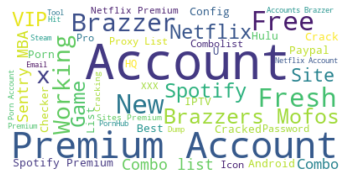

In [56]:
cracking_fire_title_doc = " ".join(titles_cracking_fire['text'])
plot_wordcloud(cracking_fire_title_doc, max_words = 50, use_stopwords_pack=True)

This wordcloud was extracted from posts:

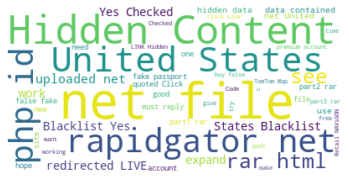

In [57]:
cracking_fire_post_doc = " ".join(posts_cracking_fire['text'])
plot_wordcloud(cracking_fire_post_doc, max_words = 50, use_stopwords_pack=True)

### Exetools
The next source of underground posts were retrieved from __Exetools__:

In [58]:
table_name = tables.loc[2, "table_name"]
table_name

'exetools_post'

This dataset contains the following:

In [59]:
exetools_db = load_mysql_in_dataframe(table_name, azs_db)
exetools_db.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag,attachmentName,authorICQ
0,90,None,Hmmm...,http:/www.forum.exetools.com/showthread.php@mo...,General Discussion,,None,None,0,"01-16-2002,20:28",1,None,"I'm a newbie when it comes to cracking, so how...","<div id=""post_message_90""> I'm a ...",None,None
1,115,None,Hmmm...,http:/www.forum.exetools.com/showthread.php@mo...,General Discussion,Anticode,Friend,Jan 2002,6,"01-17-2002,06:06",2,None,http://www.woodmann.com/upload/forumdisplay.ph...,"<div id=""post_message_115""> http:...",None,None
2,236,None,w32dasm 8.94?,http:/www.forum.exetools.com/showthread.php@mo...,General Discussion,DooGie,Friend,Jan 2002,0,"01-20-2002,05:41",1,None,Has anybody using this forum actually seen v8....,"<div id=""post_message_236""> Has a...",None,None
3,295,None,Notice!The BUG in LTR,http:/www.forum.exetools.com/showthread.php@mo...,General Discussion,,None,None,0,"01-21-2002,16:47",1,None,I forget to tell all of you a problem when I u...,"<div id=""post_message_295""> I for...",None,None
4,353,None,w32dasm 8.94?,http:/www.forum.exetools.com/showthread.php@mo...,General Discussion,,None,None,0,"01-23-2002,04:25",2,None,I sure haven't.....My version is only 8.7,"<div id=""post_message_353""> I sur...",None,None


There is a total of 24663 records and 16 columns in this dataset.

In [60]:
exetools_db.shape

(24663, 16)

In [61]:
exetools_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24663 entries, 0 to 24662
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                24663 non-null  int64 
 1   threadID              0 non-null      object
 2   threadTitle           24663 non-null  string
 3   URL                   24663 non-null  string
 4   subforum              24663 non-null  string
 5   authorName            24663 non-null  string
 6   postAuthorMembership  16359 non-null  object
 7   postAuthorJoinDate    16359 non-null  object
 8   authorReputation      24663 non-null  int64 
 9   postDate              24663 non-null  string
 10  postSequence          24663 non-null  int64 
 11  likes                 0 non-null      object
 12  flatContent           24663 non-null  string
 13  contentWithHTMLTag    24663 non-null  string
 14  attachmentName        1076 non-null   object
 15  authorICQ             0 non-null    

#### Duplicates

The count of duplicates are shown in the following table:

In [62]:
duplicate_count(exetools_db)

,duplicates
postID,0
threadID,0
threadTitle,24206
URL,22639
subforum,24663
authorName,24584
postAuthorMembership,16358
postAuthorJoinDate,16355
authorReputation,24661
postDate,185


In [63]:
duplicated_column_value_count(exetools_db, ['flatContent'])

flatContent
                                                      5
--not needed anymore--                                3
@besoeso If you want something to be added, cr...     2
Best wishes and happy long life                       2
CAN ANYBODY SAY ME HOW CAN SOME PROGRAMS TO HI...     2
Cheers.                                               2
Congratulations                                       2
Congratulations!                                      4
Congratulations, and best wishes for the future!      2
Congratulations.                                      2
Dear forum members Wishing you the best things...     2
DnlibEditor 2.0: What's new: - On method defin...     3
Gong Xi Fa Cai                                        3
Happy New Year                                        5
Happy New Year Everyone!                              3
Happy New Year my friends                             2
Happy New Year to all zeuscane                        2
Happy New Year!                     

#### Preprocessing

In [64]:
title_exetools_db = preprocess_posts(exetools_db, 'threadTitle', replace_patterns=['’'], replace_values=['\''],
                                     remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:  26%|██▌       | 914/3490 [00:00<00:00, 8230.06it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 3490/3490 [00:00<00:00, 10929.60it/s]


In [65]:
len(title_exetools_db['text'])

3490

In [66]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
posts_exetools_db = preprocess_posts(exetools_db, 'flatContent', patterns=patterns, replace_patterns=['’'],
                                          replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)


Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 167/19746 [00:00<00:11, 1660.49it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 19746/19746 [00:13<00:00, 1492.43it/s]


In [67]:
len(posts_exetools_db['text'])

19746

#### Wordcloud
Wordcloud of post titles:

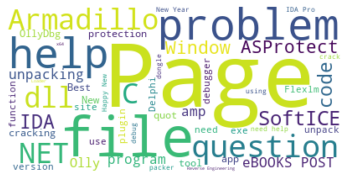

In [68]:
exetools_title_doc = " ".join(title_exetools_db['text'])
plot_wordcloud(exetools_title_doc, max_words = 50, use_stopwords_pack=True)

Wordcloud of posts:

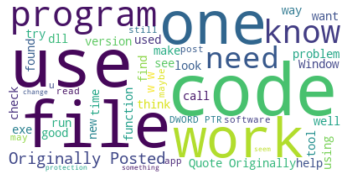

In [69]:
exetools_post_doc = " ".join(posts_exetools_db['text'])
plot_wordcloud(exetools_post_doc, max_words = 50, use_stopwords_pack=True)

### Garage4Hackers
AZSecure dataset also contains a set of posts fetched from __Garage4Hackers__ forums.

In [70]:
table_name = tables.loc[3, "table_name"]
table_name

'garage4hackers_posts'

Each entry in the dataset holds the following information:

In [71]:
garage4hackers_db = load_mysql_in_dataframe(table_name, azs_db)
garage4hackers_db.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag,attachmentName,authorICQ
0,13,7,Disclaimer,http://garage4hackers.com/showthread.php?t=7,Garage Rules,Admin,None,Jul 2010,None,"07-06-2010,",1,None,\r\n \r\n Disclaimer \r\n \r\n1. All the infor...,"\r\n <blockquote class=""postcontent resto...",None,None
1,14,8,Please Read the Rules before You Post,http://garage4hackers.com/showthread.php?t=8,Garage Rules,Admin,None,Jul 2010,None,"07-06-2010,",1,None,General Rules All posts must be written in Eng...,"<blockquote class=""postcontent restore...",None,None
2,16,10,Virtualization Security-Posts Eberly,http://garage4hackers.com/showthread.php?t=10,Cloud Computing,fb1h2s,None,Jul 2010,None,"07-07-2010,",1,None,\r\n \r\n Orginal Post:http://www.orkut.co.in/...,"\r\n <blockquote class=""postcontent resto...",None,None
3,17,10,Virtualization Security-Posts Eberly,http://garage4hackers.com/showthread.php?t=10,Cloud Computing,fb1h2s,None,Jul 2010,None,"07-07-2010,",2,None,\r\n \r\n ViMtruder v1.0 virtual machine troja...,"\r\n <blockquote class=""postcontent resto...",None,None
4,18,10,Virtualization Security-Posts Eberly,http://garage4hackers.com/showthread.php?t=10,Cloud Computing,fb1h2s,None,Jul 2010,None,"07-07-2010,",3,None,\r\n \r\n b0nd - [manage] \nMac Exploit Enters...,"\r\n <blockquote class=""postcontent resto...",None,None


This dataset contains 8700 posts and 16 columns.

In [72]:
garage4hackers_db.shape

(8700, 16)

In [73]:
garage4hackers_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                8700 non-null   int64 
 1   threadID              8700 non-null   int64 
 2   threadTitle           8700 non-null   string
 3   URL                   8700 non-null   string
 4   subforum              8700 non-null   string
 5   authorName            8700 non-null   string
 6   postAuthorMembership  0 non-null      object
 7   postAuthorJoinDate    8685 non-null   string
 8   authorReputation      0 non-null      object
 9   postDate              8700 non-null   string
 10  postSequence          8700 non-null   int64 
 11  likes                 0 non-null      object
 12  flatContent           8700 non-null   string
 13  contentWithHTMLTag    8700 non-null   string
 14  attachmentName        0 non-null      object
 15  authorICQ             0 non-null      

#### Duplicates

The number of duplicates found in this dataset are summarized in the following table:

In [74]:
duplicate_count(garage4hackers_db)

,duplicates
postID,0
threadID,7957
threadTitle,7988
URL,7952
subforum,8700
authorName,8212
postAuthorMembership,0
postAuthorJoinDate,8684
authorReputation,0
postDate,8294


In [75]:
duplicated_column_value_count(garage4hackers_db, ['flatContent'])

flatContent
Floor Function here nice one Brother , like it !      2
Once you get crash after disabling memory prot...     2
To respectful admins and the real hackers of t...     2
\r\n \r\n AboutGround Zero Summit \r\nSeptembe...     2
\r\n \r\n Awesome share bro \r\n                      2
\r\n \r\n Gr88 job bondd... keep rocking..!!!!...     2
\r\n \r\n Hello there! \r\nI want some sources...     2
\r\n \r\n Hi, \r\nFeels great to be a part of ...     2
\r\n \r\n I have gone through the tool and dow...     2
\r\n \r\n Nice share bro\r\n                          2
\r\n \r\n Python material:- \nCBT.Shell_Perl_P...     2
\r\n \r\n Set up your own Pen-testing/Hacking ...     2
\r\n \r\n Step 1: Identify the target and it\'...     2
\r\n \r\n Thanks for your nice information.\r\n       2
\r\n \r\n That reminds me of MIG Logcleaner, t...     2
\r\n \r\n That\'s a good one Sagar. \nThanks f...     2
\r\n \r\n Welcome on board \r\n                       7
\r\n \r\n Welcome to G4H Family bro.

#### Preprocessing

In [76]:
title_garage4hackers_db = preprocess_posts(garage4hackers_db, 'threadTitle', replace_patterns=['’'],
                                           replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:  40%|███▉      | 889/2230 [00:00<00:00, 8883.13it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 2230/2230 [00:00<00:00, 10090.52it/s]


In [77]:
len(title_garage4hackers_db['text'])

2230

In [78]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
posts_garage4hackers_db = preprocess_posts(garage4hackers_db, 'flatContent', patterns=patterns, replace_patterns=['’'],
                                           replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)


Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 78/7275 [00:00<00:09, 763.63it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 7275/7275 [00:06<00:00, 1056.47it/s]


In [79]:
len(posts_garage4hackers_db['text'])

7275

#### Wordcloud
Post titles wordcloud:

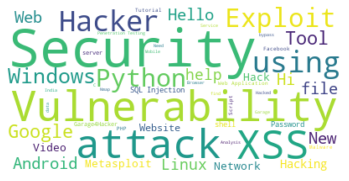

In [80]:
garage4hackers_title_doc = " ".join(title_garage4hackers_db['text'])
plot_wordcloud(garage4hackers_title_doc, max_words = 50, stopwords=['n'], use_stopwords_pack=True)

Wordcloud of posts:

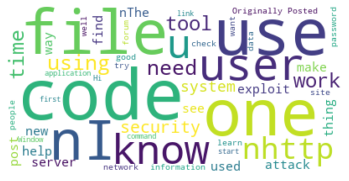

In [81]:
garage4hackers_post_doc = " ".join(posts_garage4hackers_db['text'])
plot_wordcloud(garage4hackers_post_doc, max_words = 50, stopwords=['n'], use_stopwords_pack=True)

### HackHound
The last dataset retrieved from AZSecure contains a group of posts from __HackHound__ forums.

In [82]:
table_name = tables.loc[4, "table_name"]
table_name

'hackhoundposts'

The data stored in this dataset looks like this:

In [83]:
hackhound_db = load_mysql_in_dataframe(table_name, azs_db)
hackhound_db.head()

,postid,threadid,authorID,URL,subforum,threadTitle,authorName,postdatetime,postSequence,flatContent,contentwithhtmltag,userTitle,hasAttachment
0,20,14,0,,AlphaControls v8.01 Beta - Extra - HackHound,alphacontrols-v801-beta,Andain,2012-10-12 00:00:00,1,Skin component for Delphi ... Attached Files a...,Skin component for Delphi ... <span rel='light...,Newbie,None
1,43,26,0,,R.A.I.D. Beta - Malware Samples - HackHound,raid-beta,SolarStone,2012-10-13 00:00:00,1,This was an official scam at opensc.ws so it s...,This was an official scam at opensc.ws so it s...,Beginner,None
2,80,38,0,,Delphi 7 Personal Edition - Development Softwa...,delphi-7-personal-edition,omc,2012-10-13 00:00:00,1,Borland has previously offered a downloadable ...,Borland has previously offered a downloadable ...,Beginner,None
3,163,71,0,,Movies Warez - Resources - HackHound,movies-warez,P3H3X,2012-10-14 00:00:00,1,go there : Please Login or Register to see thi...,go there :<br /><br /><p class='message error'...,Member,None
4,485,133,0,,Watch streaming movies online - Resources - Ha...,watch-streaming-movies-online,omc,2012-10-19 00:00:00,1,When your bored and wanna watch a movie: Pleas...,When your bored and wanna watch a movie:<br />...,Beginner,None


This dataset contains a total of 1611 entries and 13 columns.

In [84]:
hackhound_db.shape

(1611, 13)

In [85]:
hackhound_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   postid              1611 non-null   int64 
 1   threadid            1611 non-null   int64 
 2   authorID            1611 non-null   int64 
 3   URL                 1611 non-null   string
 4   subforum            1611 non-null   string
 5   threadTitle         1611 non-null   string
 6   authorName          1611 non-null   string
 7   postdatetime        1611 non-null   string
 8   postSequence        1611 non-null   int64 
 9   flatContent         1611 non-null   string
 10  contentwithhtmltag  1611 non-null   string
 11  userTitle           1528 non-null   string
 12  hasAttachment       0 non-null      object
dtypes: int64(4), object(1), string(8)
memory usage: 163.7+ KB


#### Duplicates

Duplicates values are counted in the following table:

In [86]:
duplicate_count(hackhound_db)

,duplicates
postid,0
threadid,1578
authorID,1611
URL,1611
subforum,1578
threadTitle,1578
authorName,1439
postdatetime,1538
postSequence,1611
flatContent,10


In [87]:
duplicated_column_value_count(hackhound_db, ['flatContent'])

flatContent
                                                     3
Great job                                            2
Thanks                                               3
Whathefuck :S If you wanna use a vpn you gotta...    2
dtype: int64

In [88]:
filter_by_word_count(hackhound_db, 'flatContent', 10)

,postid,threadid,authorID,URL,subforum,threadTitle,authorName,postdatetime,postSequence,flatContent,contentwithhtmltag,userTitle,hasAttachment
0,20,14,0,,AlphaControls v8.01 Beta - Extra - HackHound,alphacontrols-v801-beta,Andain,2012-10-12 00:00:00,1,Skin component for Delphi ... Attached Files a...,Skin component for Delphi ... <span rel='light...,Newbie,None
1,43,26,0,,R.A.I.D. Beta - Malware Samples - HackHound,raid-beta,SolarStone,2012-10-13 00:00:00,1,This was an official scam at opensc.ws so it s...,This was an official scam at opensc.ws so it s...,Beginner,None
2,80,38,0,,Delphi 7 Personal Edition - Development Softwa...,delphi-7-personal-edition,omc,2012-10-13 00:00:00,1,Borland has previously offered a downloadable ...,Borland has previously offered a downloadable ...,Beginner,None
3,163,71,0,,Movies Warez - Resources - HackHound,movies-warez,P3H3X,2012-10-14 00:00:00,1,go there : Please Login or Register to see thi...,go there :<br /><br /><p class='message error'...,Member,None
4,485,133,0,,Watch streaming movies online - Resources - Ha...,watch-streaming-movies-online,omc,2012-10-19 00:00:00,1,When your bored and wanna watch a movie: Pleas...,When your bored and wanna watch a movie:<br />...,Beginner,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,27843,4381,0,,"New Router, which one would you suggest? - Net...",new-router-which-one-would-you-suggest,x_h0rr0r_x,2014-02-24 00:00:00,6,I have an Asus and Motorola router..Both have ...,<p>I have an Asus and Motorola router..Both ha...,Expert,None
1606,27850,4392,0,,Sections update - Suggestions & Support - Hack...,sections-update,x58,2014-02-24 00:00:00,2,Next up would be Android. It's language is Jav...,"<blockquote class=""ipsBlockquote"" data-author...",Advanced,None
1608,27857,4342,0,,Crack Delphi Xe5 ??? - Development Software - ...,crack-delphi-xe5,Guest_sergioarantes_*,2014-02-24 00:00:00,6,"Boa Tarde! Gostaria de saber se alguÃ©m, conse...","<blockquote class=""ipsBlockquote"" data-author...",<NA>,None
1609,27859,4381,0,,"New Router, which one would you suggest? - Net...",new-router-which-one-would-you-suggest,Becks,2014-02-24 00:00:00,7,"Thanks for your replies guy, really helping me...","<p>Thanks for your replies guy, really helping...",IntermediateMember,None


#### Preprocessing

In [89]:
title_hackhound_db = preprocess_posts(hackhound_db, 'threadTitle', replace_patterns=['’'],
                                      replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...: 100%|██████████| 213/213 [00:00<00:00, 12503.66it/s]

Reading twitter - 1grams ...


In [90]:
len(title_hackhound_db['text'])

213

In [91]:
patterns = ['((?:(?<=[^a-zA-Z0-9\'’])|(?<=^)|(?<=y)|(?<=you))(t+[hanksxz]{4,}|x+|t+)( *[y]+[ou]*)*)+(?=\\W+|$)']
posts_hackhound_db = preprocess_posts(hackhound_db, 'flatContent', patterns=patterns, replace_patterns=['’'],
                                      replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

/tmp/ipykernel_42242/1625022407.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = df[column_name].str.contains(pattern, case=case, regex=True)
/tmp/ipykernel_42242/1550771929.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts[column_name] = replace_post_patterns(posts, column_name, pattern, value)


Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:  16%|█▋        | 215/1317 [00:00<00:00, 2025.17it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 1317/1317 [00:00<00:00, 1602.36it/s]


In [92]:
len(posts_hackhound_db['text'])

1317

#### Wordcloud
Wordcloud for post titles:

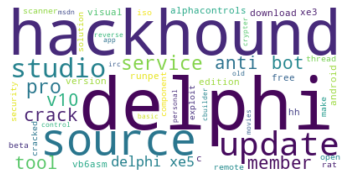

In [93]:
hackhound_title_doc = " ".join(title_hackhound_db['text'])
plot_wordcloud(hackhound_title_doc, max_words = 50, use_stopwords_pack=True)

Wordclod of posts:

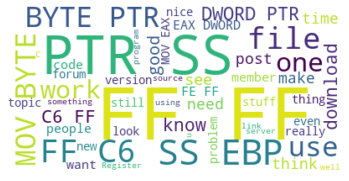

In [94]:
stopwords = ["lot", "much", "thank", "man", "see", "thanks", "bro", "many", "need", "guy", "will", "alot", "hope", "nice", "thx", "sir", "check", "u", "mate", "give", "great", "friend", "good", "use", "work", "know", "one", "find", "w", "think", "want", "Originally", "n", "S", "nI"]
hackhound_post_doc = " ".join(posts_hackhound_db['text'])
plot_wordcloud(hackhound_post_doc, max_words = 50, use_stopwords_pack=True)

## Cyber threatning tweets
Tweets are classify into three main categories: `threat`, `business` and `irrelevant`.

In [95]:
collection_name = 'tweets'
collection_name

'tweets'

The data stored in the collection looks like:

In [96]:
cyberthreat_db = load_mongodb_collection_in_dataframe(collection_name, cyberthreat_conn)
cyberthreat_db.head()

,_id,date,id,relevant,text,tweet,type,watson,annotation
0,5b88752abb325e65390af240,2018-08-30 22:52:25,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,[vulnerability],"{'usage': {'text_units': 1, 'text_characters':...",irrelevant
1,5b8875d5bb325e65a22cf81b,2018-08-30 22:55:15,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,[ransomware],"{'usage': {'text_units': 1, 'text_characters':...",business
2,5b88768dbb325e65fa7e78e3,2018-08-30 22:58:20,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,[ransomware],"{'usage': {'text_units': 1, 'text_characters':...",business
3,5b8876f9bb325e65fa7e78e4,2018-08-30 23:00:08,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,[ddos],"{'usage': {'text_units': 1, 'text_characters':...",threat
4,5b8876f9bb325e65fa7e78e5,2018-08-30 23:00:09,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,[leak],"{'usage': {'text_units': 1, 'text_characters':...",threat


This database contains up to 21368 records and 9 fields:
1. __`_id`:__ The internal unique identifier of the Tweet in the DB.
2. __`date`:__ Date tweet was retrieved.
3. __`id`:__ Tweet ID.
4. __`relevant`:__ Preannotation done automatically from ibm watson topic modeling: true if classification is relevant.
5. __`text`:__ Tweet text content.
6. __`tweet`:__ Tweet object containing text and associated metadata.
7. __`type`:__ List of types of vulnerabilities that this tweet represents.
8. __`watson`:__ Watson object that is the result from running topic modeling on IBM Watson.
9. __`annotation`:__ Tweet classification label: "relevant", "irrelevant" or "business" depending on the annotation by user.

In [97]:
cyberthreat_db.shape

(21368, 9)

In [98]:
cyberthreat_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   _id         21368 non-null  object        
 1   date        21368 non-null  datetime64[ns]
 2   id          21368 non-null  object        
 3   relevant    21368 non-null  bool          
 4   text        21368 non-null  object        
 5   tweet       21368 non-null  object        
 6   type        21368 non-null  object        
 7   watson      21368 non-null  object        
 8   annotation  17536 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(7)
memory usage: 1.3+ MB


#### Tweet field

In [99]:
cyberthreat_data_db = pd.DataFrame(cyberthreat_db['tweet'].tolist())
cyberthreat_data_db.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,timestamp_ms,possibly_sensitive,display_text_range,extended_entities,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,withheld_in_countries
0,Thu Aug 30 22:52:25 +0000 2018,1035299228984041472,1035299228984041472,Best way to build empathy is through honesty a...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,1535669545776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thu Aug 30 22:55:15 +0000 2018,1035299941932036096,1035299941932036096,Cryptocurrency Scams Replacing Ransomware as A...,"<a href=""https://SYSNI.UK"" rel=""nofollow"">SYSN...",False,NaN,None,NaN,None,...,1535669715756,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thu Aug 30 22:58:20 +0000 2018,1035300715470757889,1035300715470757889,Cryptocurrency Scams Replacing Ransomware as A...,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",False,NaN,None,NaN,None,...,1535669900182,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thu Aug 30 23:00:08 +0000 2018,1035301167952211969,1035301167952211969,Protect your customers access Prestashop Ant...,"<a href=""https://dapicart.com/"" rel=""nofollow""...",False,NaN,None,NaN,None,...,1535670008062,False,"[0, 96]","{'media': [{'id': 1035301166706569219, 'id_str...",NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Aug 30 23:00:09 +0000 2018,1035301173178249217,1035301173178249217,Data leak from Huazhu Hotels may affect 130 mi...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,...,1535670009308,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
cyberthreat_data_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 21368 non-null  object 
 1   id                         21368 non-null  int64  
 2   id_str                     21368 non-null  object 
 3   text                       21368 non-null  object 
 4   source                     21368 non-null  object 
 5   truncated                  21368 non-null  bool   
 6   in_reply_to_status_id      2771 non-null   float64
 7   in_reply_to_status_id_str  2771 non-null   object 
 8   in_reply_to_user_id        3351 non-null   float64
 9   in_reply_to_user_id_str    3351 non-null   object 
 10  in_reply_to_screen_name    3351 non-null   object 
 11  user                       21368 non-null  object 
 12  geo                        38 non-null     object 
 13  coordinates                38 non-null     obj

This column contains 21368 Tweet objects with 36 fields. The most relevant fields are listed here:
1. __`created_at`:__ Tweet creation date.
2. __`id`:__ Tweet ID.
3. __`text`:__ Tweet text content.
4. __`truncated`:__ Tells whether the value of the `text` property was truncated.
5. __`in_reply_to_status_id`:__ Indicates the Tweet ID the current Tweet is replying to.
6. __`in_reply_to_user_id`:__ Points the user ID a Tweet replies to.
7. __`in_reply_to_screen_name`:__ Original Tweet's author screen name a Tweet replies to.
8. __`user`:__ User object metadata object.
9. __`geo`:__ Object representing the latitude and longitude of the Tweet location. Deprecated: use coordinates instead when applicable.
10. __`coordinates`:__ Object representing the geographic location of a Tweet.
11. __`place`:__ Object representing a place where the Tweet is associated to.
12. __`is_quote_status`:__ Indicates if the current Tweet is a quote Tweet.
13. __`quote_count`:__ Number of times this Tweet has been quoted.
14. __`reply_count`:__ Number of times this Tweet has been replied to.
15. __`retweet_count`:__ Number of times this Tweet has been ReTweeted.
16. __`favorite_count`:__ Number of times this Tweet has been liked by other Twitter users.
17. __`lang`:__ Tweet language.
18. __`possibly_sensitive`:__ Flag indicating if a Tweet contains a link or media with sensitive content.
19. __`quoted_status_id`:__ Quoted Tweet ID.
20. __`withheld_in_countries`:__ List of countries where this Tweet has been withheld.

In [101]:
cyberthreat_data_db.shape

(21368, 36)

In [102]:
cyberthreat_data_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 21368 non-null  object 
 1   id                         21368 non-null  int64  
 2   id_str                     21368 non-null  object 
 3   text                       21368 non-null  object 
 4   source                     21368 non-null  object 
 5   truncated                  21368 non-null  bool   
 6   in_reply_to_status_id      2771 non-null   float64
 7   in_reply_to_status_id_str  2771 non-null   object 
 8   in_reply_to_user_id        3351 non-null   float64
 9   in_reply_to_user_id_str    3351 non-null   object 
 10  in_reply_to_screen_name    3351 non-null   object 
 11  user                       21368 non-null  object 
 12  geo                        38 non-null     object 
 13  coordinates                38 non-null     obj

#### User field

In [103]:
cyberthreat_user_db = pd.DataFrame(cyberthreat_data_db['user'].tolist())
cyberthreat_user_db.head()

,id,id_str,name,screen_name,location,url,description,translator_type,protected,verified,...,profile_text_color,profile_use_background_image,profile_image_url,profile_image_url_https,profile_banner_url,default_profile,default_profile_image,following,follow_request_sent,notifications
0,617849132,617849132,Wave Wizard 💧,martellwith2Ls,RIP Mommy and Uncle Kenny,None,RIP mama I love you ❤️| Kiara J👸🏾,none,False,False,...,333333,True,http://pbs.twimg.com/profile_images/1028458721...,https://pbs.twimg.com/profile_images/102845872...,https://pbs.twimg.com/profile_banners/61784913...,True,False,None,None,None
1,2530505347,2530505347,SYSNI,SYSNIUK,Cyberspace,None,It is our business to know what other people d...,none,False,False,...,000000,False,http://pbs.twimg.com/profile_images/8159458878...,https://pbs.twimg.com/profile_images/815945887...,https://pbs.twimg.com/profile_banners/25305053...,False,False,None,None,None
2,3387744717,3387744717,Quantus,QuantusTecSol,Canada,http://quantus.biz,Just another IT Guy! #JentuTech #WorldWifi #Bl...,none,False,False,...,333333,True,http://pbs.twimg.com/profile_images/9706558235...,https://pbs.twimg.com/profile_images/970655823...,https://pbs.twimg.com/profile_banners/33877447...,True,False,None,None,None
3,2842644562,2842644562,Best Prestashop Temp,prestashop_free,None,http://mcaf.ee/n2w9z3?prestashop_free,None,none,False,False,...,333333,True,http://pbs.twimg.com/profile_images/7983024549...,https://pbs.twimg.com/profile_images/798302454...,https://pbs.twimg.com/profile_banners/28426445...,True,False,None,None,None
4,4162538387,4162538387,Blitz,BlinstrubJ,"California, USA",None,None,none,False,False,...,000000,False,http://abs.twimg.com/sticky/default_profile_im...,https://abs.twimg.com/sticky/default_profile_i...,NaN,False,False,None,None,None


The user property contains 21368 records and 39 fields. The most relevant fields are described below:
1. __`id`:__ Twitter user ID.
2. __`name`:__ The name of the user.
3. __`screen_name`:__ Unique username or alias of the user.
4. __`location`:__ String indicating the location of the account.
5. __`description`:__ String describing the user account.
6. __`followers_count`:__ Number of followers.
7. __`friends_count`:__ Number of friends.
8. __`listed_count`:__ Number of public lists that this user is a member of.
9. __`favorites_count`:__ Number of Tweets this user has liked.
10. __`statuses_count`:__ Number of Tweets and ReTweets issued by this user.
11. __`created_at`:__ Datetime the user account was created on Twitter.
12. __`lang`:__ Twitter account language.
13. __`default_profile`:__ Indicates whether the user has not altered the theme or background of their user profile.

In [104]:
cyberthreat_user_db.shape

(21368, 39)

In [105]:
cyberthreat_user_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   id                                  21368 non-null  int64 
 1   id_str                              21368 non-null  object
 2   name                                21368 non-null  object
 3   screen_name                         21368 non-null  object
 4   location                            16185 non-null  object
 5   url                                 13522 non-null  object
 6   description                         18933 non-null  object
 7   translator_type                     21368 non-null  object
 8   protected                           21368 non-null  bool  
 9   verified                            21368 non-null  bool  
 10  followers_count                     21368 non-null  int64 
 11  friends_count                       21368 non-null  in

#### Geo field

In [106]:
cyberthreat_geo_db = pd.DataFrame(cyberthreat_data_db['geo'].dropna().tolist())
cyberthreat_geo_db.head()

,type,coordinates
0,Point,"[47.378236, 8.53905487]"
1,Point,"[40.75812, -73.98808]"
2,Point,"[43.25468, -79.86136]"
3,Point,"[38.9030571, -77.02194214]"
4,Point,"[33.7489954, -84.3879824]"


There are 38 non-null geo object values with 2 fields:
1. __`type`:__ Type of coordinate
2. __`coordinates`:__ Latitude and longitude.

In [107]:
cyberthreat_geo_db.shape

(38, 2)

In [108]:
cyberthreat_geo_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         38 non-null     object
 1   coordinates  38 non-null     object
dtypes: object(2)
memory usage: 736.0+ bytes


#### Place field

In [109]:
cyberthreat_place_db = pd.DataFrame(cyberthreat_data_db['place'].dropna().tolist())
cyberthreat_place_db.head()

,id,url,place_type,name,full_name,country_code,country,bounding_box,attributes
0,c783883e2edd7454,https://api.twitter.com/1.1/geo/id/c783883e2ed...,city,West Haven,"West Haven, CT",US,United States,"{'type': 'Polygon', 'coordinates': [[[-72.9946...",{}
1,6ffcf3b0b904bbcb,https://api.twitter.com/1.1/geo/id/6ffcf3b0b90...,admin,Kentucky,"Kentucky, USA",US,United States,"{'type': 'Polygon', 'coordinates': [[[-89.5715...",{}
2,206c436ce43a43a3,https://api.twitter.com/1.1/geo/id/206c436ce43...,city,Madrid,"Madrid, España",ES,España,"{'type': 'Polygon', 'coordinates': [[[-3.88900...",{}
3,00e55e2b4c491c5f,https://api.twitter.com/1.1/geo/id/00e55e2b4c4...,city,Abuja,"Abuja, Nigeria",NG,Nigeria,"{'type': 'Polygon', 'coordinates': [[[7.304554...",{}
4,70b15cd26c69f608,https://api.twitter.com/1.1/geo/id/70b15cd26c6...,city,Palm Beach Gardens,"Palm Beach Gardens, FL",US,United States,"{'type': 'Polygon', 'coordinates': [[[-80.1772...",{}


There are 407 non-null place records with 9 fields. The main fields are the following:
1. __`id`:__ Unique place ID.
2. __`place_type`:__ Indicates the type of place.
3. __`name`:__ Place's name.
4. __`full_name`:__ Full place's name.
5. __`country_code`:__ Capital two character code representation of the country.
6. __`bounding_box`:__ Type and coordinates of the place bounding box (longitude, latitude).

In [110]:
cyberthreat_place_db.shape

(407, 9)

In [111]:
cyberthreat_place_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            407 non-null    object
 1   url           407 non-null    object
 2   place_type    407 non-null    object
 3   name          407 non-null    object
 4   full_name     407 non-null    object
 5   country_code  407 non-null    object
 6   country       407 non-null    object
 7   bounding_box  407 non-null    object
 8   attributes    407 non-null    object
dtypes: object(9)
memory usage: 28.7+ KB


#### Coordinates field

In [112]:
cyberthreat_coordinates_db = pd.DataFrame(cyberthreat_data_db['coordinates'].dropna().tolist())
cyberthreat_coordinates_db.head()

,type,coordinates
0,Point,"[8.53905487, 47.378236]"
1,Point,"[-73.98808, 40.75812]"
2,Point,"[-79.86136, 43.25468]"
3,Point,"[-77.02194214, 38.9030571]"
4,Point,"[-84.3879824, 33.7489954]"


There are 38 non-null coordinates objects with 2 fields:
1. __`type`:__ Type of coordinate.
2. __`coordinates`:__ Longitude and latitude.

In [113]:
cyberthreat_coordinates_db.shape

(38, 2)

In [114]:
cyberthreat_coordinates_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         38 non-null     object
 1   coordinates  38 non-null     object
dtypes: object(2)
memory usage: 736.0+ bytes


#### Pre-processing

In [158]:
cyberthreat_result = preprocess_posts(cyberthreat_db, 'text', replace_patterns=['’'], replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 204/21368 [00:00<00:10, 2039.30it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 21368/21368 [00:25<00:00, 845.26it/s] 


#### Word count

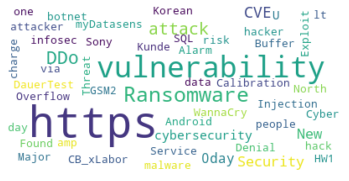

In [160]:
stopwords = ["user", "number", "url", "CO"]
cyberthreat_docs = " ".join(cyberthreat_result['text'])
plot_wordcloud(cyberthreat_docs, max_words = 50, use_stopwords_pack=True, stopwords=stopwords)

### Cyberbulling dataset

In [117]:
collection_name = 'tweets'
collection_name

'tweets'

In [118]:
cyberbulling_db = load_mongodb_collection_in_dataframe(collection_name, cyberbulling_conn)
cyberbulling_db.head()

,_id,data,includes,matching_rules,Cyberbullying,Insult,Profanity,Sarcasm,Threat,Exclusion,Pornography,Spam
0,6258147ee7661aa16e3871e9,"{'attachments': None, 'author_id': '2368960458...","{'media': None, 'places': None, 'polls': None,...",None,0,0,0,0,0,0,0,0
1,6258147ee7661aa16e3871ea,"{'attachments': None, 'author_id': '2205484344...","{'media': None, 'places': None, 'polls': None,...",None,0,0,1,0,0,0,0,0
2,6258147ee7661aa16e3871eb,"{'attachments': None, 'author_id': '29472734',...","{'media': None, 'places': None, 'polls': None,...",None,0,0,1,0,0,0,0,0
3,6258147ee7661aa16e3871ec,"{'attachments': None, 'author_id': '1092125386...","{'media': None, 'places': None, 'polls': None,...",None,0,0,0,0,0,0,0,0
4,6258147ee7661aa16e3871ed,"{'attachments': None, 'author_id': '8040637837...","{'media': None, 'places': None, 'polls': None,...",None,0,1,1,0,0,0,0,0


This database contains up to 21368 records and 9 fields:
1. __`_id`:__ The internal unique identifier of the Tweet in the DB.
2. __`data`:__ Tweet object containing text and associated metadata.
3. __`includes`:__ List of objects included in a certain Tweet.
4. __`matching_rules`:__ Rule by which a Tweet was captured via filtered stream.
5. __`Cyberbulling`:__ Label set to 1 if the Tweet belongs to the cyberbulling class.
6. __`Insult`:__ Label set to 1 if the Tweet belongs to the insult class.
7. __`Profanity`:__ Label set to 1 if the Tweet belongs to the profanity class.
8. __`Sarcasm`:__ Label set to 1 if the Tweet belongs to the sarcasm class.
9. __`Threat`:__ Label set to 1 if the Tweet belongs to the threat class.
10. __`Exclusion`:__ Label set to 1 if the Tweet belongs to the exclusion class.
11. __`Pornography`:__ Label set to 1 if the Tweet belongs to the pornography class.
12. __`Spam`:__ Label set to 1 if the Tweet belongs to the spam class.

In [119]:
cyberbulling_db.shape

(26022, 12)

In [120]:
cyberbulling_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26022 entries, 0 to 26021
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             26022 non-null  object
 1   data            26022 non-null  object
 2   includes        26022 non-null  object
 3   matching_rules  0 non-null      object
 4   Cyberbullying   26022 non-null  int64 
 5   Insult          26022 non-null  int64 
 6   Profanity       26022 non-null  int64 
 7   Sarcasm         26022 non-null  int64 
 8   Threat          26022 non-null  int64 
 9   Exclusion       26022 non-null  int64 
 10  Pornography     26022 non-null  int64 
 11  Spam            26022 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 2.4+ MB


#### Data field

In [121]:
cyberbulling_data_db = pd.DataFrame(cyberbulling_db['data'].tolist())
cyberbulling_data_db.head()

,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,non_public_metrics,organic_metrics,possibly_sensitive,promoted_metrics,public_metrics,referenced_tweets,reply_settings,source,text,withheld
0,None,2368960458,None,1134395760844427264,2019-05-31T09:46:40.000000Z,"{'annotations': [{'end': 105, 'normalized_text...",None,1134395760844427264,None,en,None,None,False,None,"{'like_count': 0, 'quote_count': 0, 'reply_cou...",None,everyone,Katherine T Owen,"Seriously, I think it is a grave fault in life...",None
1,None,2205484344,None,1132686520333283329,2019-05-26T16:34:45.000000Z,"{'annotations': None, 'cashtags': None, 'descr...",None,1132686520333283329,None,en,None,None,False,None,"{'like_count': 0, 'quote_count': 0, 'reply_cou...","[{'id': '1132314410373066752', 'type': 'retwee...",everyone,Twitter for iPhone,RT @feliciadetty: I hate when people stick up ...,None
2,None,29472734,None,1135066181386342401,2019-06-02T06:10:40.000000Z,"{'annotations': None, 'cashtags': None, 'descr...",None,1135066181386342401,None,en,None,None,False,None,"{'like_count': 0, 'quote_count': 0, 'reply_cou...","[{'id': '1134784500372770817', 'type': 'quoted'}]",everyone,Twitter for iPhone,A reminder that this Catholic man is a cunt. h...,None
3,None,1092125386744442880,None,1132834361945014273,2019-05-27T02:22:13.000000Z,"{'annotations': None, 'cashtags': None, 'descr...",None,1132834361945014273,None,en,None,None,False,None,"{'like_count': 0, 'quote_count': 0, 'reply_cou...","[{'id': '1132802363939532808', 'type': 'retwee...",everyone,Twitter for Android,RT @Headsnipe011: If people spent all their ti...,None
4,None,804063783786336258,None,1132742436185411584,2019-05-26T20:16:56.000000Z,None,None,1132742436185411584,None,en,None,None,False,None,"{'like_count': 1, 'quote_count': 0, 'reply_cou...",None,everyone,Twitter for iPhone,i will you whore,None


asgajhd

In [122]:
cyberbulling_data_db.shape

(26022, 20)

In [123]:
cyberbulling_data_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26022 entries, 0 to 26021
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   attachments          2468 non-null   object
 1   author_id            26022 non-null  object
 2   context_annotations  5669 non-null   object
 3   conversation_id      26022 non-null  object
 4   created_at           26022 non-null  object
 5   entities             21198 non-null  object
 6   geo                  846 non-null    object
 7   id                   26022 non-null  object
 8   in_reply_to_user_id  7494 non-null   object
 9   lang                 26022 non-null  object
 10  non_public_metrics   0 non-null      object
 11  organic_metrics      0 non-null      object
 12  possibly_sensitive   26022 non-null  bool  
 13  promoted_metrics     0 non-null      object
 14  public_metrics       26022 non-null  object
 15  referenced_tweets    16717 non-null  object
 16  repl

#### Includes field

In [124]:
cyberbulling_includes_db = pd.DataFrame(cyberbulling_db['includes'].tolist())
cyberbulling_includes_db.head()

,media,places,polls,tweets,users
0,None,None,None,None,"[{'created_at': '2014-03-02T14:32:47.000000Z',..."
1,None,None,None,"[{'attachments': None, 'author_id': '63341223'...","[{'created_at': '2013-11-20T19:38:55.000000Z',..."
2,None,None,None,"[{'attachments': None, 'author_id': '108025909...","[{'created_at': '2009-04-07T15:40:28.000000Z',..."
3,None,None,None,"[{'attachments': None, 'author_id': '342675158...","[{'created_at': '2019-02-03T18:19:17.000000Z',..."
4,None,None,None,None,"[{'created_at': '2016-11-30T20:45:19.000000Z',..."


In [125]:
cyberbulling_includes_db.shape

(26022, 5)

In [126]:
cyberbulling_includes_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26022 entries, 0 to 26021
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   media   2421 non-null   object
 1   places  846 non-null    object
 2   polls   12 non-null     object
 3   tweets  16717 non-null  object
 4   users   26022 non-null  object
dtypes: object(5)
memory usage: 1016.6+ KB


#### Users object

In [127]:
data = {}
for users in cyberbulling_includes_db['users']:
    for user in users:
        for field, value in user.items():
            if field not in data.keys():
                data[field] = [value]
            else:
                data[field] = data[field] + [value]

cyberbulling_users_db = pd.DataFrame(data=data)
cyberbulling_users_db.head()

,created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld
0,2014-03-02T14:32:47.000000Z,Health writer. CFS/ME since 1991. Bedbound 14 ...,"{'annotations': None, 'cashtags': None, 'descr...",2368960458,UK,HealingCFSME,1129393030123970560,https://pbs.twimg.com/profile_images/597491764...,False,"{'followers_count': 3032, 'following_count': 3...",https://t.co/eTuwhURw2t,HealingCFSME,False,None
1,2013-11-20T19:38:55.000000Z,,None,2205484344,None,ht,None,https://pbs.twimg.com/profile_images/147199849...,False,"{'followers_count': 149, 'following_count': 16...",,HollyCaptain,False,None
2,2009-04-07T15:40:28.000000Z,"Nottingham based, HR professional - have an od...",None,29472734,"Nottingham, UK",Wayne 🏳️‍🌈,1202468155693654017,https://pbs.twimg.com/profile_images/145397433...,False,"{'followers_count': 298, 'following_count': 15...",,wayne_dooley,False,None
3,2019-02-03T18:19:17.000000Z,MAGA. New account for debbie111..,None,1092125386744442880,None,Debbie222,None,https://pbs.twimg.com/profile_images/112575145...,False,"{'followers_count': 2459, 'following_count': 3...",,Debbie22210,False,None
4,2016-11-30T20:45:19.000000Z,wishing to end up like a fool running their mo...,None,804063783786336258,00:00:00:00,kayla🦋,1383412952766681095,https://pbs.twimg.com/profile_images/138544187...,False,"{'followers_count': 315, 'following_count': 21...",,koolaboolabingo,False,None


In [128]:
cyberbulling_users_db.shape

(26022, 14)

In [129]:
cyberbulling_users_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26022 entries, 0 to 26021
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   created_at         26022 non-null  object
 1   description        26022 non-null  object
 2   entities           11106 non-null  object
 3   id                 26022 non-null  object
 4   location           18240 non-null  object
 5   name               26022 non-null  object
 6   pinned_tweet_id    14690 non-null  object
 7   profile_image_url  26022 non-null  object
 8   protected          26022 non-null  bool  
 9   public_metrics     26022 non-null  object
 10  url                26022 non-null  object
 11  username           26022 non-null  object
 12  verified           26022 non-null  bool  
 13  withheld           0 non-null      object
dtypes: bool(2), object(12)
memory usage: 2.4+ MB


#### Media field

In [133]:
cyberbulling_media_db = cyberbulling_includes_db.dropna(subset='media')

data = {}
for users in cyberbulling_media_db['media']:
    for user in users:
        for field, value in user.items():
            if field not in data.keys():
                data[field] = [value]
            else:
                data[field] = data[field] + [value]

cyberbulling_media_db = pd.DataFrame(data=data)
cyberbulling_media_db.head()

,alt_text,duration_ms,height,media_key,non_public_metrics,organic_metrics,preview_image_url,promoted_metrics,public_metrics,type,url,width
0,None,NaN,1136,3_1135042226369642496,None,None,None,None,None,photo,https://pbs.twimg.com/media/D8B65CPUwAARqvX.jpg,640
1,None,NaN,1217,3_1135042239707533312,None,None,None,None,None,photo,https://pbs.twimg.com/media/D8B65z7U0AAmFrS.jpg,720
2,None,NaN,2046,3_1133551006061604872,None,None,None,None,None,photo,https://pbs.twimg.com/media/D7suolsWsAgklVi.jpg,1561
3,None,NaN,600,3_1133443460919246848,None,None,None,None,None,photo,https://pbs.twimg.com/media/D7rM0o0UwAAoCMZ.jpg,600
4,None,NaN,2048,3_1134894736643223552,None,None,None,None,None,photo,https://pbs.twimg.com/media/D7_0wAMUcAAEr5L.jpg,1634


In [134]:
cyberbulling_media_db.shape

(2340, 12)

In [135]:
cyberbulling_media_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   alt_text            1 non-null      object 
 1   duration_ms         20 non-null     float64
 2   height              2340 non-null   int64  
 3   media_key           2340 non-null   object 
 4   non_public_metrics  0 non-null      object 
 5   organic_metrics     0 non-null      object 
 6   preview_image_url   341 non-null    object 
 7   promoted_metrics    0 non-null      object 
 8   public_metrics      20 non-null     object 
 9   type                2340 non-null   object 
 10  url                 1999 non-null   object 
 11  width               2340 non-null   int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 219.5+ KB


#### Places field

In [136]:
cyberbulling_places_db = cyberbulling_includes_db.dropna(subset='places')

data = {}
for users in cyberbulling_places_db['places']:
    for user in users:
        for field, value in user.items():
            if field not in data.keys():
                data[field] = [value]
            else:
                data[field] = data[field] + [value]

cyberbulling_places_db = pd.DataFrame(data=data)
cyberbulling_places_db.head()

,contained_within,country,country_code,full_name,geo,id,name,place_type
0,None,Estados Unidos,US,"Williamston, MI","{'bbox': [-84.313017, 42.67321, -84.241169, 42...",f39f5341d5a51513,Williamston,city
1,None,Estados Unidos,US,"Corpus Christi, TX","{'bbox': [-97.662618, 27.578509, -97.202232, 2...",a3d770a00f15bcb1,Corpus Christi,city
2,None,Reino Unido,GB,"Malton, England","{'bbox': [-0.8213024, 54.1181598, -0.7682901, ...",4eb0e04a5e921604,Malton,city
3,None,Estados Unidos,US,"Huntington, VA","{'bbox': [-77.0806839, 38.78152, -77.056976, 3...",03a8232acb787108,Huntington,city
4,None,Estados Unidos,US,"Georgia, USA","{'bbox': [-85.605166, 30.355644, -80.742567, 3...",7142eb97ae21e839,Georgia,admin


In [137]:
cyberbulling_places_db.shape

(846, 8)

In [138]:
cyberbulling_places_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   contained_within  0 non-null      object
 1   country           846 non-null    object
 2   country_code      846 non-null    object
 3   full_name         846 non-null    object
 4   geo               846 non-null    object
 5   id                846 non-null    object
 6   name              846 non-null    object
 7   place_type        846 non-null    object
dtypes: object(8)
memory usage: 53.0+ KB


#### Geo field

In [139]:
cyberbulling_geo_db = pd.DataFrame(cyberbulling_places_db['geo'].tolist())
cyberbulling_geo_db.head()

,bbox,coordinates,place_id,properties,type
0,"[-84.313017, 42.67321, -84.241169, 42.715413]",None,None,{},Feature
1,"[-97.662618, 27.578509, -97.202232, 27.895793]",None,None,{},Feature
2,"[-0.8213024, 54.1181598, -0.7682901, 54.1483305]",None,None,{},Feature
3,"[-77.0806839, 38.78152, -77.056976, 38.8004452]",None,None,{},Feature
4,"[-85.605166, 30.355644, -80.742567, 35.000771]",None,None,{},Feature


In [141]:
cyberbulling_places_db.shape

(846, 8)

In [140]:
cyberbulling_places_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   contained_within  0 non-null      object
 1   country           846 non-null    object
 2   country_code      846 non-null    object
 3   full_name         846 non-null    object
 4   geo               846 non-null    object
 5   id                846 non-null    object
 6   name              846 non-null    object
 7   place_type        846 non-null    object
dtypes: object(8)
memory usage: 53.0+ KB


#### Polls field

In [145]:
cyberbulling_polls_db = cyberbulling_includes_db.dropna(subset='places')

data = {}
for users in cyberbulling_polls_db['places']:
    for user in users:
        for field, value in user.items():
            if field not in data.keys():
                data[field] = [value]
            else:
                data[field] = data[field] + [value]

cyberbulling_polls_db = pd.DataFrame(data=data)
cyberbulling_polls_db.head()

,contained_within,country,country_code,full_name,geo,id,name,place_type
0,None,Estados Unidos,US,"Williamston, MI","{'bbox': [-84.313017, 42.67321, -84.241169, 42...",f39f5341d5a51513,Williamston,city
1,None,Estados Unidos,US,"Corpus Christi, TX","{'bbox': [-97.662618, 27.578509, -97.202232, 2...",a3d770a00f15bcb1,Corpus Christi,city
2,None,Reino Unido,GB,"Malton, England","{'bbox': [-0.8213024, 54.1181598, -0.7682901, ...",4eb0e04a5e921604,Malton,city
3,None,Estados Unidos,US,"Huntington, VA","{'bbox': [-77.0806839, 38.78152, -77.056976, 3...",03a8232acb787108,Huntington,city
4,None,Estados Unidos,US,"Georgia, USA","{'bbox': [-85.605166, 30.355644, -80.742567, 3...",7142eb97ae21e839,Georgia,admin


In [146]:
cyberbulling_polls_db.shape

(846, 8)

In [147]:
cyberbulling_polls_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   contained_within  0 non-null      object
 1   country           846 non-null    object
 2   country_code      846 non-null    object
 3   full_name         846 non-null    object
 4   geo               846 non-null    object
 5   id                846 non-null    object
 6   name              846 non-null    object
 7   place_type        846 non-null    object
dtypes: object(8)
memory usage: 53.0+ KB


#### Preprocessing

In [148]:
cyberbulling_result = preprocess_posts(cyberbulling_data_db, 'text', replace_patterns=['’'], replace_values=['\''], remove_stopwords=True, remove_punctuation=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


PreProcessing...:   1%|          | 259/25947 [00:00<00:10, 2566.78it/s]

Reading twitter - 1grams ...


PreProcessing...: 100%|██████████| 25947/25947 [00:08<00:00, 3167.09it/s]


#### Word cloud

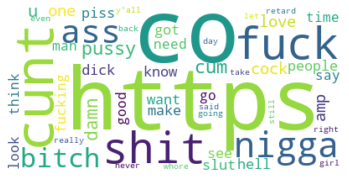

In [155]:
cyberbulling_doc = " ".join(cyberbulling_result['text'])
stopwords = ["RT"]
plot_wordcloud(cyberbulling_doc, max_words = 50, use_stopwords_pack=True, stopwords=stopwords)

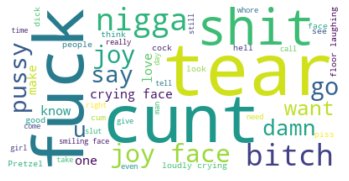

In [154]:
cyberbulling_doc = " ".join(cyberbulling_result['preprocessed_text'])
stopwords=["user", "url", "rt", "number"]
plot_wordcloud(cyberbulling_doc, max_words = 50, use_stopwords_pack=True, stopwords=stopwords)

#### Data normalization
This section aims to normalize the semi-structured data from this dataset and manually select relevant fields and collect them in a tabular format. The fields of choice are:

1. __`id`:__ Tweet ID.
2. __`text`:__ Tweet text content.
3. __`in_reply_to_status_id`:__ Indicates the Tweet ID the current Tweet is replying to.
4. __`in_reply_to_user_id`:__ Points the user ID a Tweet replies to.
5. __`in_reply_to_screen_name`:__ Original Tweet's author screen name a Tweet replies to.
6. __`user`:__ User object metadata object.
7. __`geo`:__ Object representing the latitude and longitude of the Tweet location. Deprecated: use coordinates instead when applicable.
8. __`coordinates`:__ Object representing the geographic location of a Tweet.
9. __`place`:__ Object representing a place where the Tweet is associated to.
10. __`is_quote_status`:__ Indicates if the current Tweet is a quote Tweet.
11. __`quote_count`:__ Number of times this Tweet has been quoted.
12. __`reply_count`:__ Number of times this Tweet has been replied to.
13. __`retweet_count`:__ Number of times this Tweet has been ReTweeted.
14. __`favorite_count`:__ Number of times this Tweet has been liked by other Twitter users.
15. __`possibly_sensitive`:__ Flag indicating if a Tweet contains a link or media with sensitive content.
16. __`quoted_status_id`:__ Quoted Tweet ID.
17. __`withheld_in_countries`:__ List of countries where this Tweet has been withheld.
18. __`created_at`:__ Tweet creation date.

## Cyberbulling tweets
A dataset with a colorful set of cyberbulling Tweets classified in different categories: `cyberbulling`, `insult`, `profanity`, `sarcasm`, `threat`, `exclusion`, `porn` and `spam`

The collections contains up to ___ records with a total of 9 properties:
1. __`_id`:__ Unique identifier of the document
2. __`data`:__ Tweet data and metadata contained in the target Tweet.
3. __`matching_rules`:__ The streaming filter rule which captured the Tweet.
4. __`media`:__ Attached media files to a specific Tweet.
5. __`places`:__ List of referenced places in Tweets.
6. __`polls`:__ List of polls attached to Tweets.
7. __`tweets`:__ List of referenced Retweet s, Quoted Tweets or replies.
8. __`users`:__ List of referenced Tweet authors.
9. __`include`:__ Artifact column which encapsulates columns 4-8.

## Creating a Data Warehouse
The following section attempts to build an Online Analitical Processing (OLAP) cube in MySQL. Queries will be performed in the multidimensional cube in order to retrieve pieces of data relevant to be analyzed.
<img src="tweets-dw.png" width="1000">

#### Fetch items in batches

In [143]:
def fetch_in_batches(db: MySQLConnection, table: str, values: List|Tuple, select: List = [], cols: List|Tuple = [], multi: bool = False) -> List:
    cursor = db.cursor()
    select = ",".join(select) if len(select) > 0 else "*"
    rows = []
    for value in values:
        select_sql = f"SELECT {select} FROM {table}"
        for i, col in enumerate(cols):
            conjunction = "WHERE"
            if select_sql.__contains__("WHERE"):
                conjunction = "AND"
            select_sql = select_sql + f" {conjunction} {col} = {value[i]}"
        cursor.execute(select_sql)
        matching_rows = cursor.fetchall()
        rows = rows + matching_rows

    cursor.close()
    return rows

#### Insert items in batches

In [142]:
def insert_in_batches(db: MySQLConnection, table: str, cols: List|Tuple, values: List[Tuple]) -> None:
    cursor = db.cursor()
    placeholders = ["%s"] * len(cols)
    insert_sql = f"INSERT INTO {table} ({','.join(cols)}) VALUES ({','.join(placeholders)})"
    values = [value for value in values]

    try:
        cursor.executemany(insert_sql, values)
        db.commit()
    except IntegrityError as e:
        print(f'Could not insert {", ".join(cols)} values: {values}')

    cursor.close()

#### Insert dates

In [141]:
def insert_missing_records(db: MySQLConnection, table: str, cols: List, existing_rows: List,
                           values_to_insert: List, search_column_index: List[Tuple]) -> List:
    insert_values = []
    existing_row_col_index = search_column_index
    for value_list in values_to_insert:
        matching = True
        for idx, value in enumerate(value_list):
            i = existing_row_col_index[idx]
            existing_values = [val[i] for val in existing_rows]
            if not value in existing_values:
                matching = False

        if not matching:
            insert_values.append(value_list)

    if len(insert_values) > 0:
        insert_in_batches(db, table, cols, insert_values)

In [140]:
def fetch_or_insert_datetime(db: MySQLConnection, date_time_dict: Dict) -> Dict:
    entities = date_time_dict.keys()
    next_stage_ids = {}
    for entity in entities:
        table_name = entity + "_dimension"
        entity_values = date_time_dict[entity]
        rows = fetch_in_batches(db, table_name, entity_values, cols=[entity])
        values_to_insert = [value for value in entity_values]
        insert_missing_records(db, table_name, [entity], rows, values_to_insert, (1,))
        found_ids = fetch_in_batches(db, table_name, entity_values, ['id'], cols=[entity])
        next_stage_ids[entity] = found_ids

    parent_dimensions = ['date', 'time']
    current_stage_ids = next_stage_ids.copy()
    next_stage_ids = {}
    for i, dimension_name in enumerate(parent_dimensions):
        table_name = dimension_name + '_dimension'
        values = []
        if i == 0:
            values = [[year[0], month[0], day[0]] for year, month, day
                      in zip(current_stage_ids['year'], current_stage_ids['month'], current_stage_ids['day'])]
        elif i == 1:
            values = [(hour[0], minute[0], second[0]) for hour, minute, second
                      in zip(current_stage_ids['hour'], current_stage_ids['minute'], current_stage_ids['second'])]
        col_names = [entity + '_id' for entity in list(entities)[i*3:(i+1)*3]]
        rows = fetch_in_batches(db, table_name, values, cols=col_names)
        insert_missing_records(db, table_name, col_names, rows, values, (1, 2, 3))
        found_ids = fetch_in_batches(db, table_name, values, ['id'], cols=col_names)
        next_stage_ids[dimension_name] = [object_id[0] for object_id in found_ids]

    current_stage_ids = next_stage_ids.copy()
    next_stage_ids = {}
    parent_dimensions = ['datetime']
    for i, dimension_name in enumerate(parent_dimensions):
        table_name = dimension_name + '_dimension'
        values = [[date, time] for date, time in zip(current_stage_ids['date'], current_stage_ids['time'])]
        col_names = ['date_id', 'time_id']
        rows = fetch_in_batches(db, table_name, values, cols=col_names)
        insert_missing_records(db, table_name, col_names, rows, values, [1,2])
        found_ids = fetch_in_batches(db, table_name, values, ['id'], cols=col_names)
        next_stage_ids[dimension_name] = [object_id[0] for object_id in found_ids]

    return next_stage_ids

In [139]:
def generate_datetime_payload(date_strings: List, date_fmt: str) -> Dict:
    date_time_list = [datetime.strptime(dt, date_fmt) for dt in date_strings]
    date_time_dict = {
        'year': [(dt.year,) for dt in date_time_list],
        'month': [(dt.month,) for dt in date_time_list],
        'day': [(dt.day,) for dt in date_time_list],
        'hour': [(dt.hour,) for dt in date_time_list],
        'minute': [(dt.minute,) for dt in date_time_list],
        'second': [(dt.second + dt.microsecond / 10**6,) for dt in date_time_list]
    }

    return date_time_dict

In [147]:
def preload_date_times(db: MySQLConnection):
    loader = {
        'year': [(value,) for value in range(2006, 2023)],
        'month': [(value,) for value in range(1, 13)],
        'day': [(value,) for value in range(1, 32)],
        'hour': [(value,) for value in range(0, 24)],
        'minute': [(value,) for value in range(0, 60)],
        'second': [(value,) for value in range(0, 60)]
    }

    for entity, values in loader.items():
        table_name = entity + "_dimension"
        insert_in_batches(db, table_name, [entity], values)

In [148]:
def preload_labels(db: MySQLConnection):
    insert_in_batches(db, 'label_dimension', ['label'], [('no-threat',), ('phishing',), ('cyberbulling',), ('spam',),
                                                         ('threat',), ('hack',), ('pornography',), ('exclusion-racism',),
                                                         ('leaks',), ('other-threat',), ('dont-know',)])

In [144]:
dw_db.reconnect()
dt_dict = generate_datetime_payload(['Thu Aug 30 23:06:55 +0000 2018', 'Tue Sep 11 20:42:51 +0000 2018'],
                                        '%a %b %d %H:%M:%S %z %Y')
result = fetch_or_insert_datetime(dw_db, dt_dict)
result

{'datetime': [1, 2]}

titles_cracking_arena.keys()